Standard scanpy workflow with BBKNN batch correction

In [276]:
import scanpy as sc
import anndata
import MultiMAP
import numpy as np
from bbknn import bbknn
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
adata_10x = sc.read_h5ad("/nfs/team283/aa16/data/Zika/zikaGlioblastomas_10X_SeuratObject.h5ad")
adata_SS = sc.read_h5ad("/nfs/team283/aa16/data/Zika/zikaGlioblastomas_SS_SeuratObject.h5ad")

In [3]:
adata_10x.X = adata_10x.raw.X
adata_SS.X = adata_SS.raw.X

In [4]:
adata_10x.obs['Celltype'] = adata_10x.obs['Celltype2']
adata_SS.obs['Celltype'] = adata_SS.obs['Celltype3']

... storing 'Technology' as categorical
... storing 'ZikaExposure' as categorical
... storing 'Patient' as categorical
... storing 'Celltype' as categorical
... storing 'Celltype2' as categorical


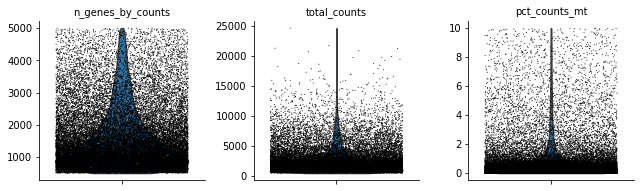

... storing 'orig.ident' as categorical
... storing 'Technology' as categorical
... storing 'ZikaExposure' as categorical
... storing 'Patient' as categorical
... storing 'predicted.id' as categorical
... storing 'Celltype' as categorical
... storing 'Celltype3' as categorical


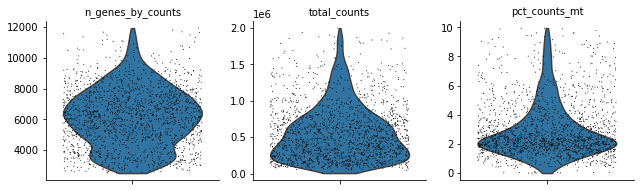

In [5]:
adata_10x.var['mt'] = adata_10x.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
adata_SS.var['mt'] = adata_SS.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata_10x, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(adata_SS, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata_10x, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)
sc.pl.violin(adata_SS, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [6]:
sc.pp.normalize_total(adata_10x, target_sum=1e4)
sc.pp.normalize_total(adata_SS, target_sum=1e4)
sc.pp.log1p(adata_10x)
sc.pp.log1p(adata_SS)
sc.pp.highly_variable_genes(adata_10x, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.highly_variable_genes(adata_SS, min_mean=0.0125, max_mean=3, min_disp=0.5)

In [7]:
adata_10x = adata_10x[:, adata_10x.var.highly_variable]
adata_SS = adata_SS[:, adata_SS.var.highly_variable]

In [8]:
sc.pp.regress_out(adata_10x, ['total_counts', 'pct_counts_mt'])
sc.pp.regress_out(adata_SS, ['total_counts', 'pct_counts_mt'])

In [9]:
sc.pp.scale(adata_10x, max_value=10)
sc.pp.scale(adata_SS, max_value=10)
sc.tl.pca(adata_10x, svd_solver='arpack')
sc.tl.pca(adata_SS, svd_solver='arpack')

In [10]:
sc.pp.neighbors(adata_10x, n_neighbors=10, n_pcs=40)
sc.pp.neighbors(adata_SS, n_neighbors=10, n_pcs=40)

In [11]:
sc.tl.umap(adata_10x)

In [12]:
sc.tl.umap(adata_SS)

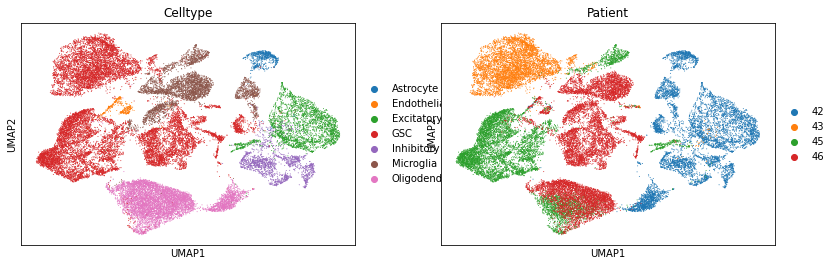

In [15]:
sc.pl.umap(adata_10x, color=['Celltype', 'Patient'])

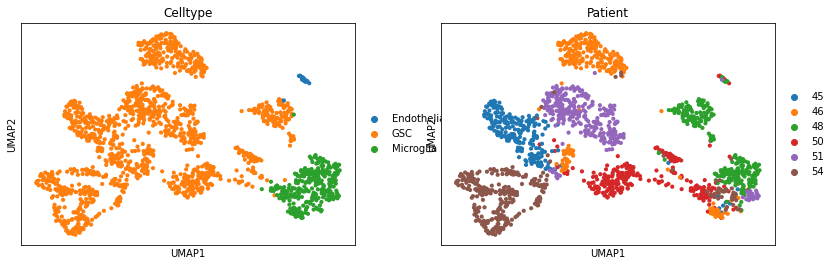

In [16]:
sc.pl.umap(adata_SS, color=['Celltype', 'Patient'])

In [27]:
bbknn(adata_10x,batch_key='Patient',trim=10000,approx=False,use_faiss=False)

In [26]:
bbknn(adata_SS,batch_key='Patient',trim=10000,approx=False,use_faiss=False)

In [29]:
sc.tl.umap(adata_10x)
sc.tl.umap(adata_SS)

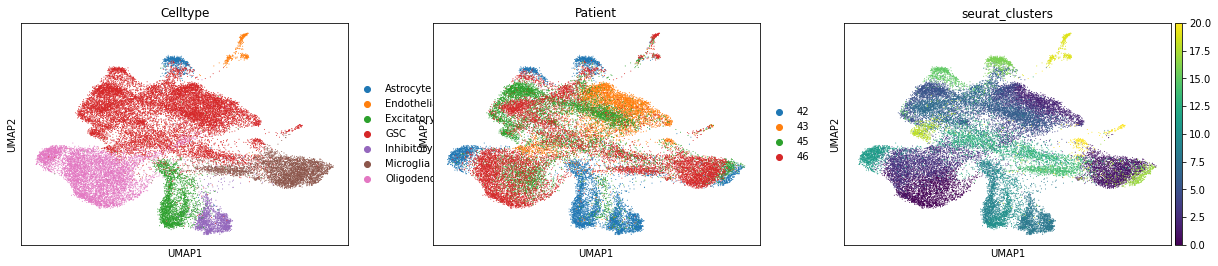

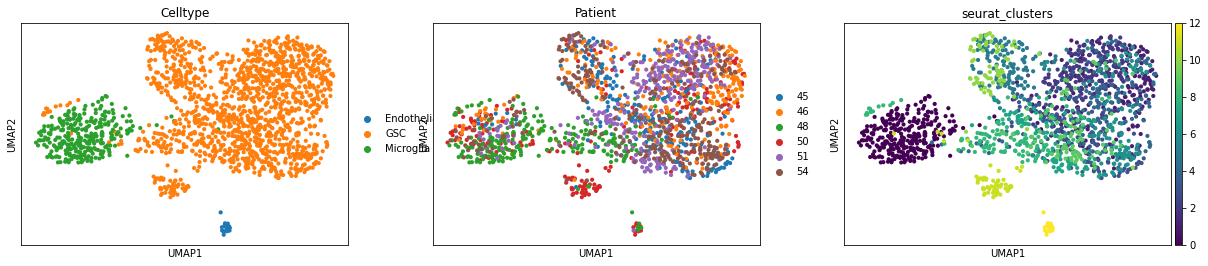

In [36]:
sc.pl.umap(adata_10x, color=['Celltype', 'Patient', 'seurat_clusters'])
sc.pl.umap(adata_SS, color=['Celltype', 'Patient', 'seurat_clusters'])

In [37]:
sc.tl.leiden(adata_10x)
sc.tl.leiden(adata_SS)

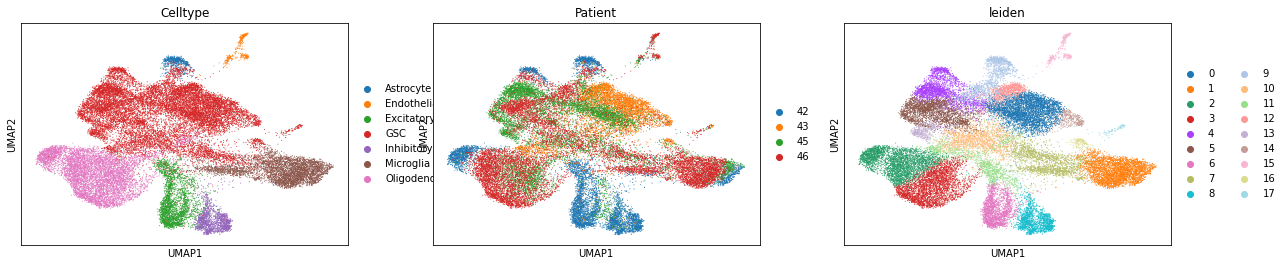

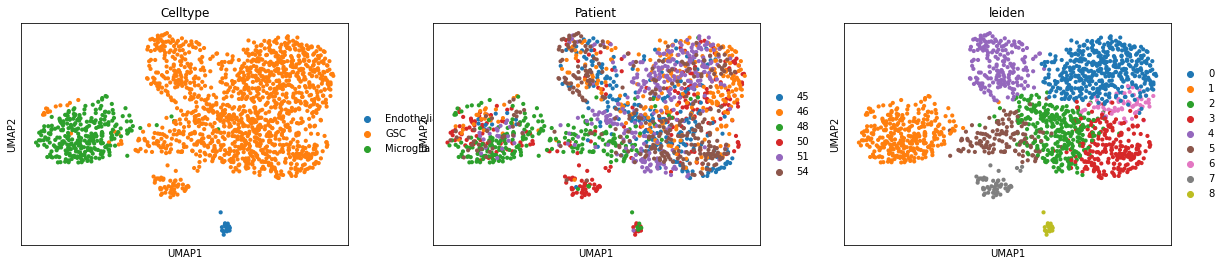

In [38]:
sc.pl.umap(adata_10x, color=['Celltype', 'Patient', 'leiden'])
sc.pl.umap(adata_SS, color=['Celltype', 'Patient', 'leiden'])

Redo data scaling but this time with all genes (don't just choose highly variable ones):

In [67]:
adata_10x_heatmap = sc.AnnData(X = adata_10x.raw.X, obs = adata_10x.obs, var = adata_10x.raw.var)
adata_SS_heatmap = sc.AnnData(X = adata_SS.raw.X, obs = adata_SS.obs, var = adata_SS.raw.var)

In [69]:
sc.pp.normalize_total(adata_10x_heatmap, target_sum=1e4)
sc.pp.normalize_total(adata_SS_heatmap, target_sum=1e4)
sc.pp.log1p(adata_10x_heatmap)
sc.pp.log1p(adata_SS_heatmap)

In [71]:
sc.pp.regress_out(adata_10x_heatmap, ['total_counts', 'pct_counts_mt'])
sc.pp.regress_out(adata_SS_heatmap, ['total_counts', 'pct_counts_mt'])

In [72]:
sc.pp.scale(adata_10x_heatmap, max_value=10)
sc.pp.scale(adata_SS_heatmap, max_value=10)

In [40]:
marker_genes_dict = {
  'Neurons' :  'RBFOX3', # NeuN
  'Immature Neurons' : 'DCX',
  'NSC.1' : 'EMX2', # Apparently also in astrocytes
  'NSC.2' : 'PAX6',
  'Activated neurons' : 'FOS', 

  'NSC and Astrocytes' : 'GFAP',

  'VGLUT1 excitatory' : 'SLC17A7',
  'VGLUT2 excitatory' : 'SLC17A6',

  'Layer I inhibitory' : 'RELN',
  'Layer II excitatory' : 'LAMP5',
  'Layer II/III-IV excitatory.1' : 'CUX1',
  'Layer II/III-IV excitatory.2' : 'CUX2',
  'Layer IV excitatory' : 'RORB',
  'Layer Va excitatory' : 'PCP4',
  'Layer Vb excitatory' : 'HTR2C',
  'Layer VIa excitatory' : 'OPRK1',
  'Layer VIb excitatory' : 'NR4A2',

  'HPA Upper layer' : 'TPPP3',
  'HPA Mid layer' : 'NECAB1',
  'HPA Lower layer' : 'PCP4',

  'GABAergic' : 'GAD1',
  'PVALB interneuron' : 'PVALB',
  'SST interneuron' : 'SST',
  '5HT3aR interneuron' : 'HTR3A',
  'VIP interneuron' : 'VIP', #Subset of 5HTraR

  'Cholinergic' : 'ACHE',
  'Dopaminergic' : 'TH',
  'Serotinergic' : 'TPH1',

  'Astrocytes' : 'AQP4',

  'Oligodendrocytes.1' : 'PLP1',
  'Oligodendrocytes.1' : 'MOG',

  'OPC' : 'PDGFRA',

  'Endothelial cells' : 'APOLD1',

  'Microglia.1' : 'CCL4',
  'Microglia.2' : 'CCL3',
  'Microglia.3' : 'TMEM119',

  'Microglia and astrocytes' : 'CX3CR1',

  'pre-Bötzinger interneurons' : 'TACR1',
  'T cells' : 'CD3G'
}

In [76]:
adata_SS_heatmap.layers['scaled'] = adata_SS_heatmap.X

In [82]:
adata_SS_heatmap.layers['scaled'][:, 0:4] = np.array(adata_SS_heatmap.obs.loc[:,['MESlike_score', 'NPClike_score', 'OPClike_score', 'AClike_score']])

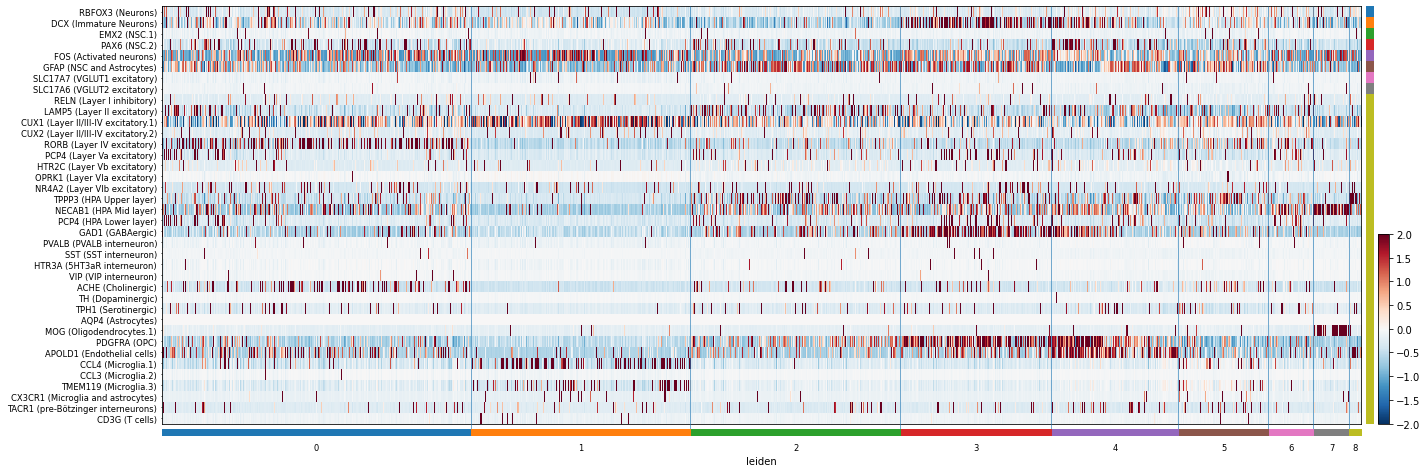

In [161]:
ax = sc.pl.heatmap(adata_SS_heatmap, marker_genes_dict, groupby='leiden', cmap='RdBu_r',
                   layer='scaled', vmin=-2, vmax=2, show = False, swap_axes = True, figsize=(22,8))
ax['heatmap_ax'].set_yticklabels([list(marker_genes_dict.values())[i] + ' (' + list(marker_genes_dict.keys())[i] + ')' for i in range(len(marker_genes_dict.keys()))])
plt.savefig('SS_ClusterHeatmap1.pdf')

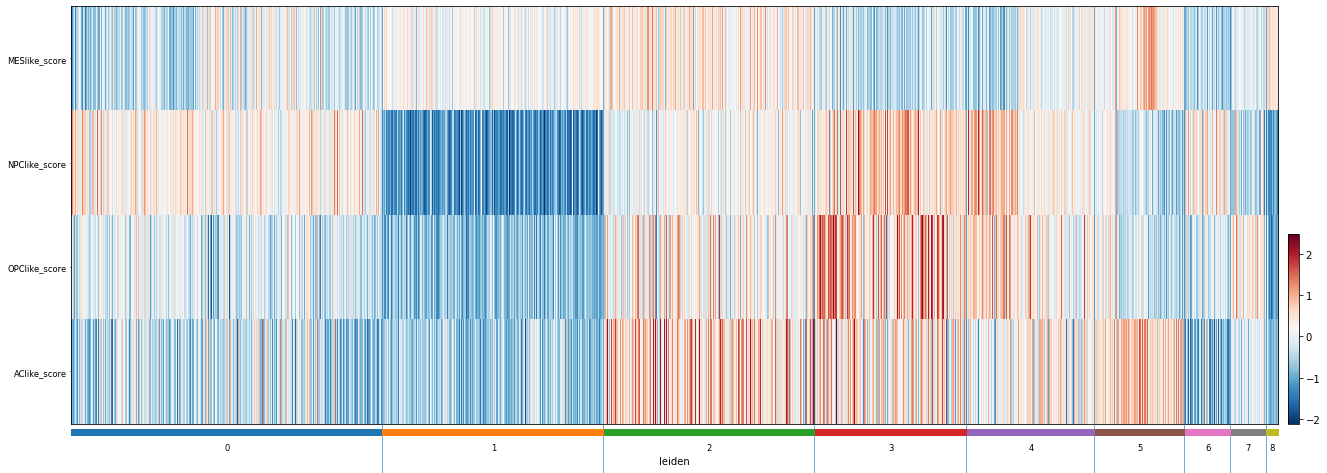

In [162]:
ax = sc.pl.heatmap(adata_SS_heatmap, adata_SS_heatmap.var_names[0:4], groupby='leiden', layer='scaled',
                  cmap='RdBu_r', dendrogram=False, swap_axes=True, figsize=(22,8), show = False)
ax['heatmap_ax'].set_yticklabels(['MESlike_score', 'NPClike_score', 'OPClike_score', 'AClike_score'])
plt.savefig('SS_ClusterHeatmap2.pdf')

In [134]:
adata_10x_heatmap.layers['scaled'] = adata_10x_heatmap.X
adata_10x_heatmap.layers['scaled'][:, 0:4] = np.array(adata_10x_heatmap.obs.loc[:,['MESlike_score', 'NPClike_score', 'OPClike_score', 'AClike_score']])

/nfs/users/nfs_a/aa16/.local/lib/python3.7/site-packages/scanpy/plotting/_anndata.py:1815: RuntimeWarning: invalid value encountered in log1p
  matrix = np.log1p(matrix)


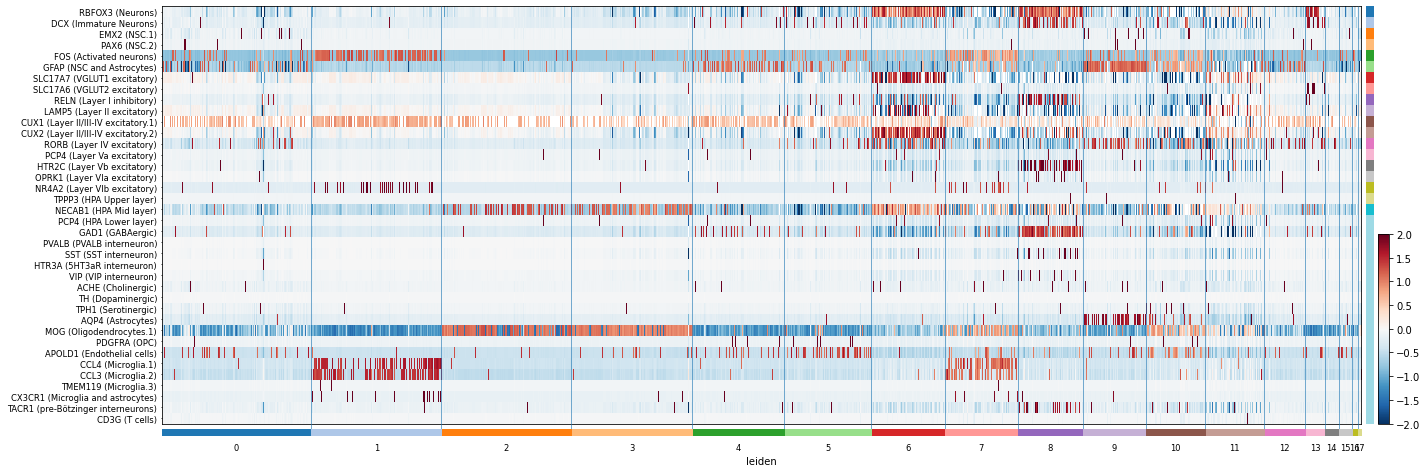

In [163]:
ax = sc.pl.heatmap(adata_10x_heatmap, marker_genes_dict, groupby='leiden', cmap='RdBu_r',
                   layer='scaled', vmin=-2, vmax=2,show = False,
                   dendrogram=False, swap_axes=True, figsize=(22,8), log = True)
ax['heatmap_ax'].set_yticklabels([list(marker_genes_dict.values())[i] + ' (' + list(marker_genes_dict.keys())[i] + ')' for i in range(len(marker_genes_dict.keys()))])
plt.savefig('10x_ClusterHeatmap1.pdf')

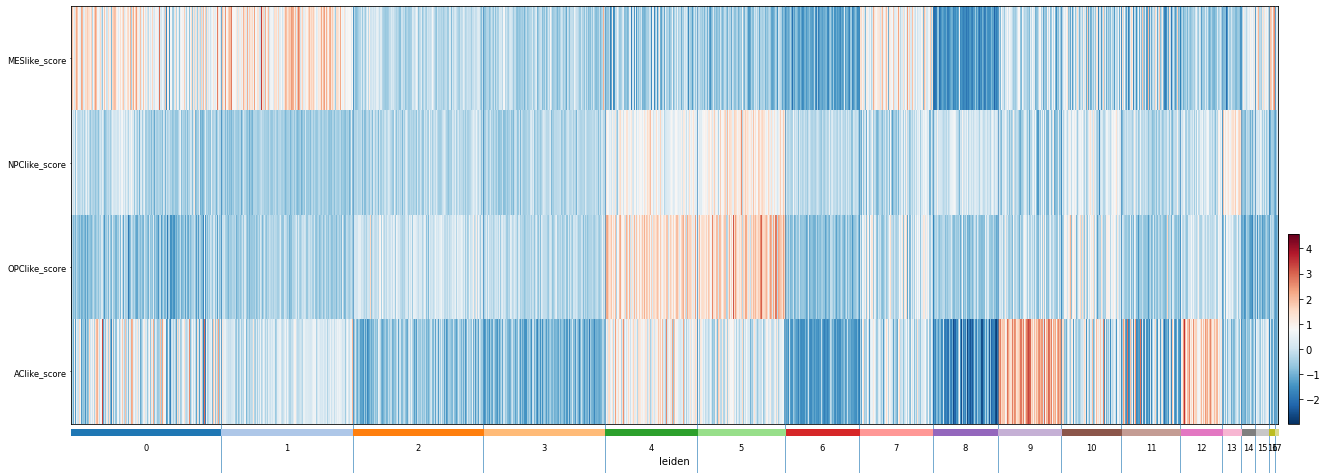

In [215]:
ax = sc.pl.heatmap(adata_10x_heatmap, adata_10x_heatmap.var_names[0:4], groupby='leiden', layer='scaled',
                  cmap='RdBu_r', dendrogram=False, swap_axes=True, figsize=(22,8), show = False)
ax['heatmap_ax'].set_yticklabels(['MESlike_score', 'NPClike_score', 'OPClike_score', 'AClike_score'])
plt.savefig('10x_ClusterHeatmap2.pdf')

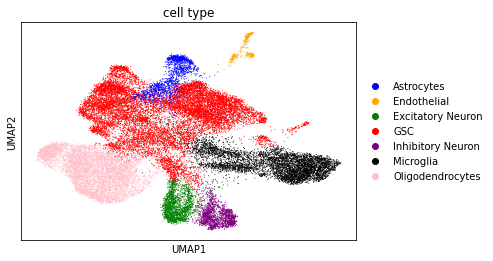

<Figure size 432x288 with 0 Axes>

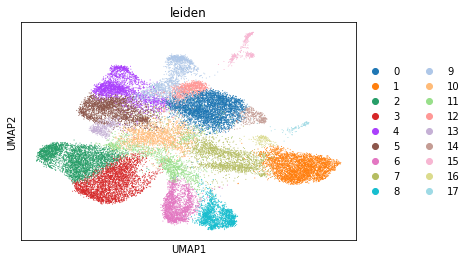

<Figure size 432x288 with 0 Axes>

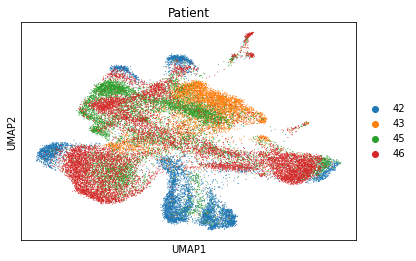

<Figure size 432x288 with 0 Axes>

In [192]:
sc.pl.umap(adata_10x, color=['cell type'])
sc.pl.umap(adata_10x, color=['leiden'])
sc.pl.umap(adata_10x, color=['Patient'])

In [245]:
new_cluster_names = ['GSC', 'Microglia', 'Oligodendrocytes', 'Oligodendrocytes', 'GSC', 'GSC', 'Excitatory Neuron',
                     'Microglia', 'Inhibitory Neuron', 'Astrocytes', 'GSC', 'GSC', 'GSC', 'GSC', 'GSC', 'Endothelial',
                     'Low Quality', 'Low Quality']
adata_10x.obs['cell type'] = None
for i in adata_10x.obs['leiden']:
    adata_10x.obs['cell type'].loc[adata_10x.obs['leiden'] == i] = new_cluster_names[int(i)]

/nfs/users/nfs_a/aa16/.local/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [180]:
new_cluster_names = ['GSC', 'Microglia', 'GSC', 'GSC', 'GSC', 'GSC', 'GSC', 'GSC', 'Endothelial Cells']
adata_SS.obs['cell type'] = None
for i in adata_SS.obs['leiden']:
    adata_SS.obs['cell type'].loc[adata_SS.obs['leiden'] == i] = new_cluster_names[int(i)]

In [246]:
adata_10x_heatmap.obs['cell type'] = adata_10x.obs['cell type']
adata_SS_heatmap.obs['cell type'] = adata_SS.obs['cell type']

In [208]:
color_map = {'Astrocytes' : 'blue',
            'Endothelial' : 'orange',
             'Excitatory Neuron': 'green',
            'GSC': 'red',
             'Inhibitory Neuron': 'purple',
             'Low Quality' : 'yellow',
             'Microglia': 'black',
             'Oligodendrocytes': 'pink'
            }

In [252]:
adata_10x.uns['cell type_colors'] = list(color_map.values())
adata_10x_heatmap.uns['cell type_colors'] = list(color_map.values())
adata_SS.uns['cell type_colors'] = ['orange', 'red', 'black']
adata_SS_heatmap.uns['cell type_colors'] = ['orange', 'red', 'black']

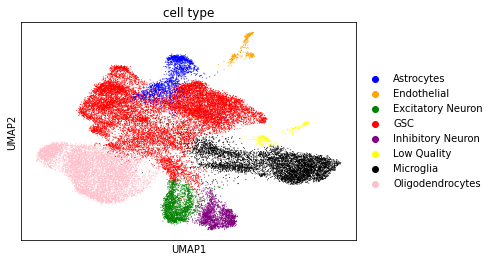

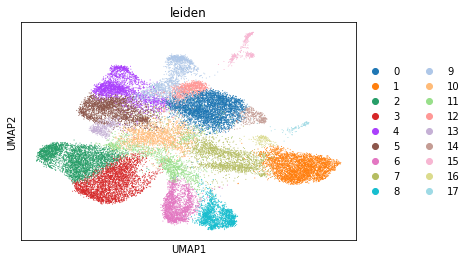

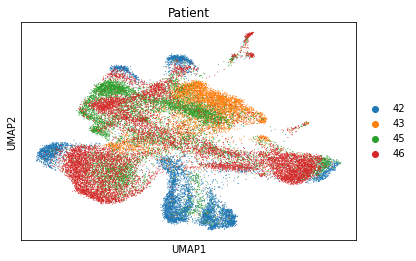

In [253]:
sc.pl.umap(adata_10x, color=['cell type'], save = '10x_UMAP_celltype.pdf')
sc.pl.umap(adata_10x, color=['leiden'], save = '10x_UMAP_leiden.pdf')
sc.pl.umap(adata_10x, color=['Patient'], save = '10x_UMAP_patient.pdf')

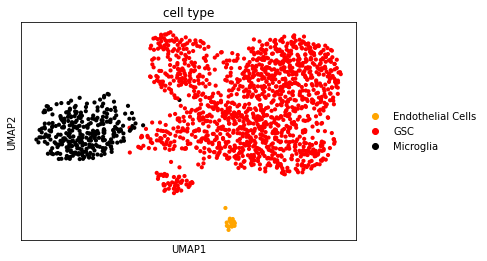

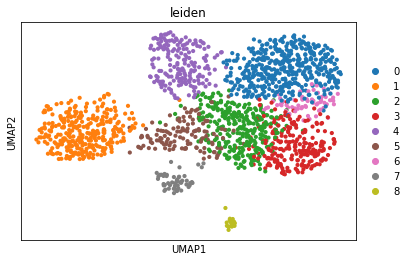

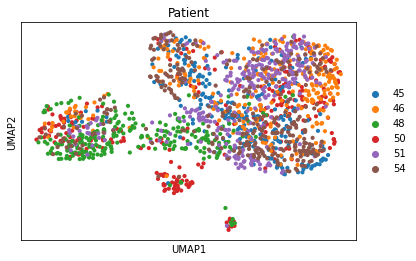

In [254]:
sc.pl.umap(adata_SS, color=['cell type'], save = 'SS_UMAP_celltype.pdf')
sc.pl.umap(adata_SS, color=['leiden'], save = 'SS_UMAP_leiden.pdf')
sc.pl.umap(adata_SS, color=['Patient'], save='SS_UMAP_patient.pdf')

/nfs/users/nfs_a/aa16/.local/lib/python3.7/site-packages/scanpy/plotting/_anndata.py:1815: RuntimeWarning: invalid value encountered in log1p
  matrix = np.log1p(matrix)


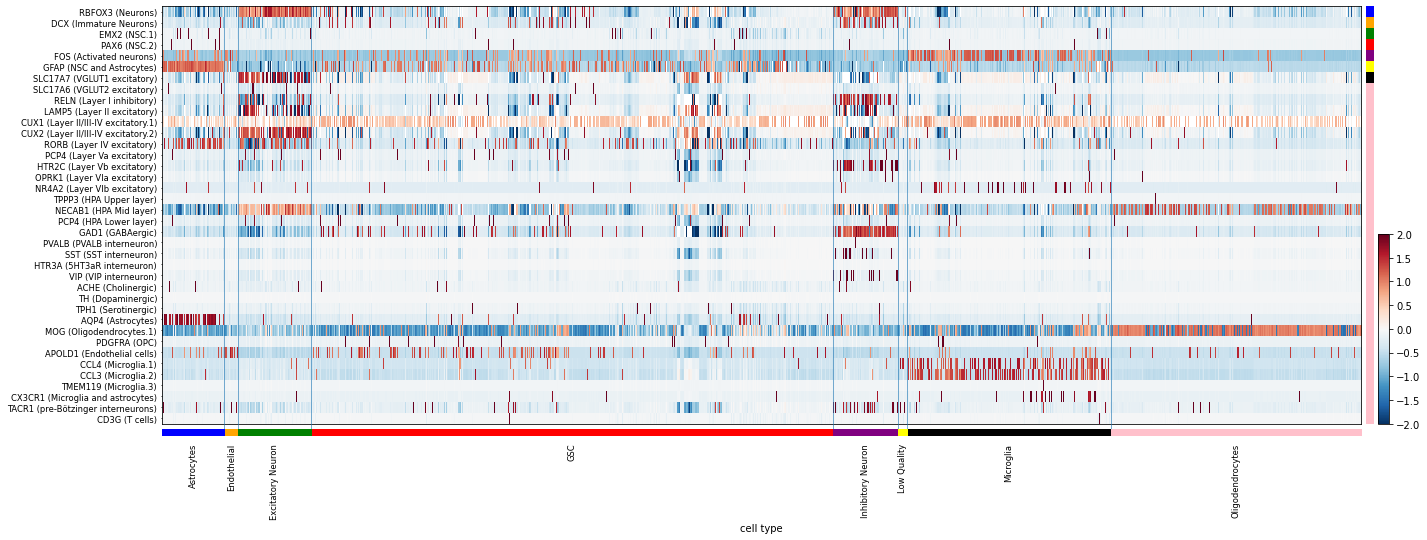

In [255]:
ax = sc.pl.heatmap(adata_10x_heatmap, marker_genes_dict, groupby='cell type', cmap='RdBu_r',
                   layer='scaled', vmin=-2, vmax=2,show = False,
                   dendrogram=False, swap_axes=True, figsize=(22,8), log = True)
ax['heatmap_ax'].set_yticklabels([list(marker_genes_dict.values())[i] + ' (' + list(marker_genes_dict.keys())[i] + ')' for i in range(len(marker_genes_dict.keys()))])
plt.savefig('10x_ClusterHeatmap1_Celltypes.pdf')

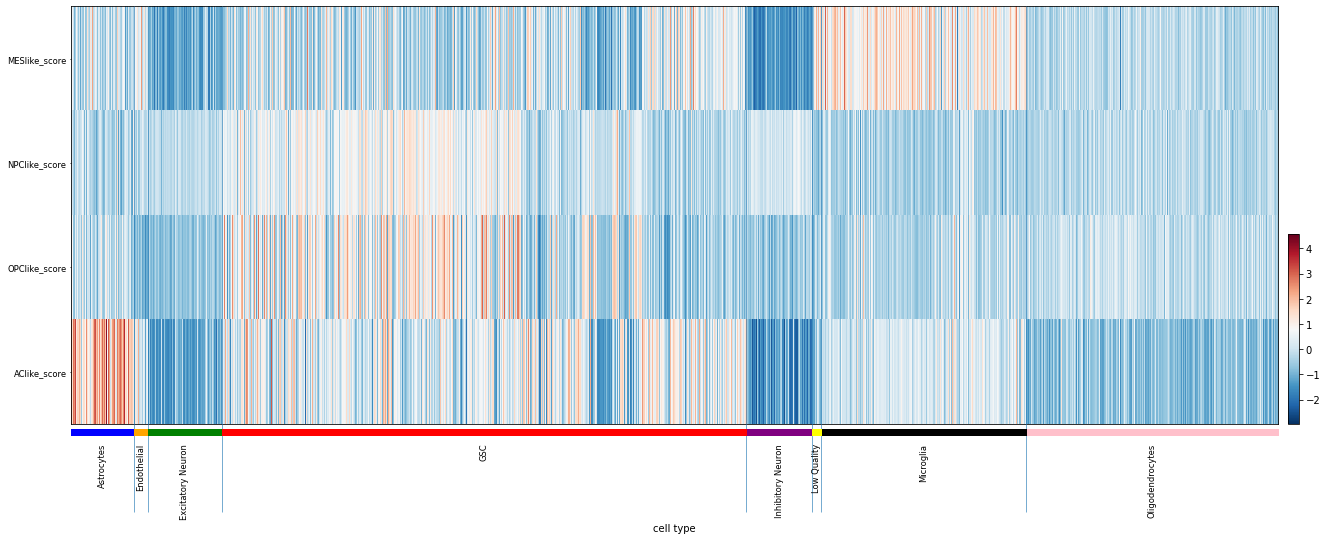

In [256]:
ax = sc.pl.heatmap(adata_10x_heatmap, adata_10x_heatmap.var_names[0:4], groupby='cell type', layer='scaled',
                  cmap='RdBu_r', dendrogram=False, swap_axes=True, figsize=(22,8), show = False)
ax['heatmap_ax'].set_yticklabels(['MESlike_score', 'NPClike_score', 'OPClike_score', 'AClike_score'])
plt.savefig('10x_ClusterHeatmap2_Celltypes.pdf')

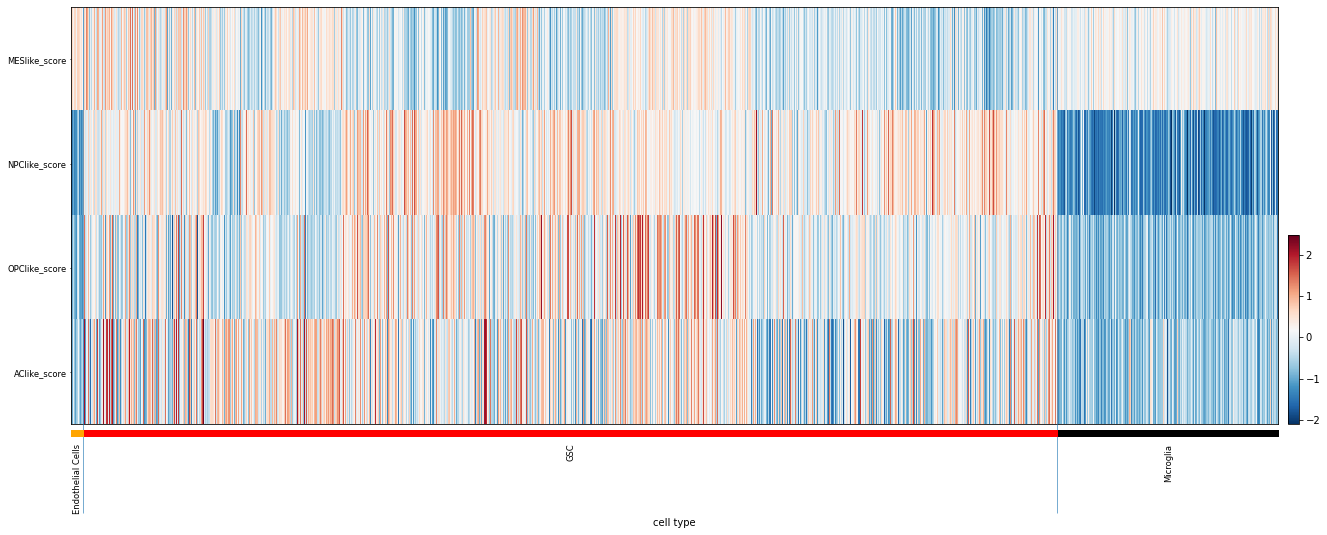

In [257]:
ax = sc.pl.heatmap(adata_SS_heatmap, adata_SS_heatmap.var_names[0:4], groupby='cell type', layer='scaled',
                  cmap='RdBu_r', dendrogram=False, swap_axes=True, figsize=(22,8), show = False)
ax['heatmap_ax'].set_yticklabels(['MESlike_score', 'NPClike_score', 'OPClike_score', 'AClike_score'])
plt.savefig('SS_ClusterHeatmap2_Celltypes.pdf')

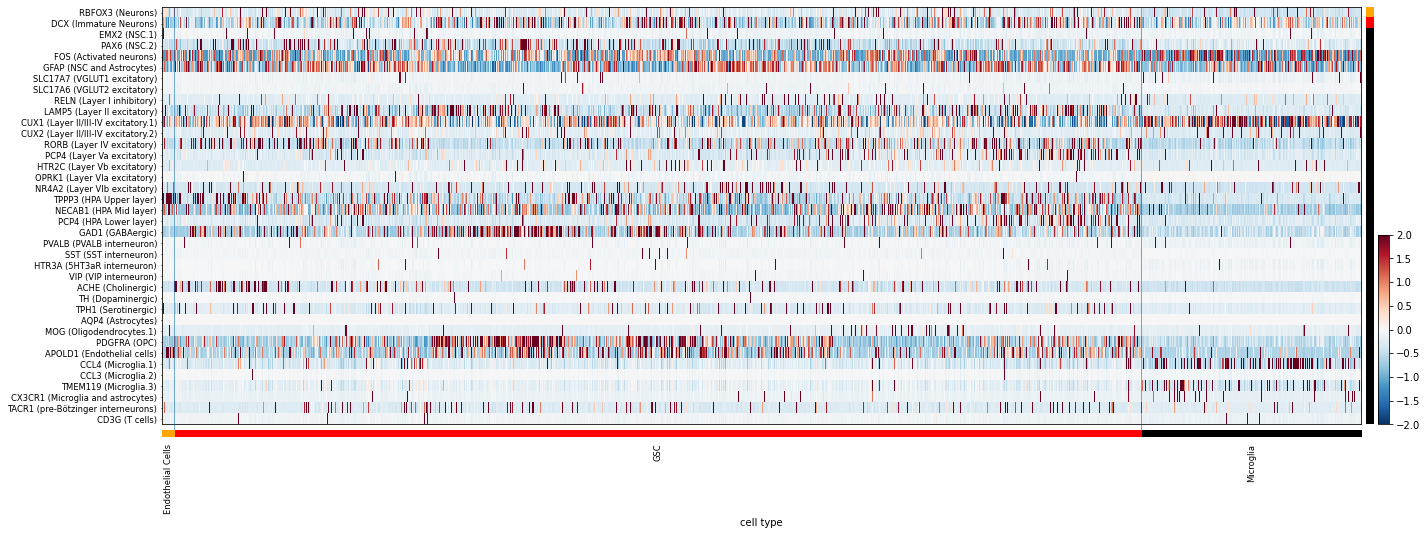

In [258]:
ax = sc.pl.heatmap(adata_SS_heatmap, marker_genes_dict, groupby='cell type', cmap='RdBu_r',
                   layer='scaled', vmin=-2, vmax=2, show = False, swap_axes = True, figsize=(22,8))
ax['heatmap_ax'].set_yticklabels([list(marker_genes_dict.values())[i] + ' (' + list(marker_genes_dict.keys())[i] + ')' for i in range(len(marker_genes_dict.keys()))])
plt.savefig('SS_ClusterHeatmap1_Celltypes.pdf')

In [294]:
celltypes_total = pd.DataFrame(columns = ['Patient', 'GSC', 'Microglia', 'Endothelial Cells'],
                               index = range(len(np.unique(adata_SS.obs['Patient']))))
celltypes_ratio = pd.DataFrame(columns = ['Patient', 'GSC', 'Microglia', 'Endothelial Cells'],
                               index = range(len(np.unique(adata_SS.obs['Patient']))))
count = 0
for x in np.unique(adata_SS.obs['Patient']):
    celltypes_total['Patient'].iloc[count] = x
    celltypes_ratio['Patient'].iloc[count] = x
    
    totals = adata_SS.obs['cell type'].loc[adata_SS.obs['Patient'] == x].value_counts()
    ratios = totals/sum(adata_SS.obs['Patient'] == x)
    
    celltypes_total['GSC'].iloc[count] = totals['GSC']
    celltypes_total['Microglia'].iloc[count] = totals['Microglia']
    celltypes_total['Endothelial Cells'].iloc[count] = totals['Endothelial Cells']
    
    celltypes_ratio['GSC'].iloc[count] = ratios['GSC']
    celltypes_ratio['Microglia'].iloc[count] = ratios['Microglia']
    celltypes_ratio['Endothelial Cells'].iloc[count] = ratios['Endothelial Cells']
    
    count = count + 1

In [298]:
celltypes_ratio.to_csv('SmartSeq_Celltype_ratios.csv')

In [299]:
celltypes_total.to_csv('SmartSeq_Celltype_totals.csv')

In [318]:
celltypes_10x = pd.DataFrame(columns = ['Cellname', 'Classification'])
celltypes_10x['Cellname'] = adata_10x.obs.index
celltypes_10x['Classification'] = np.array(adata_10x.obs['cell type'])

celltypes_SS = pd.DataFrame(columns = ['Cellname', 'Classification'])
celltypes_SS['Cellname'] = adata_SS.obs.index
celltypes_SS['Classification'] = np.array(adata_SS.obs['cell type'])

,Cellname,Classification
0,X5953STDY8282899,GSC
1,X5953STDY8282900,GSC
2,X5953STDY8282901,GSC
3,X5953STDY8282902,GSC
4,X5953STDY8282903,GSC
...,...,...
1721,X5953STDY8614292,GSC
1722,X5953STDY8614294,GSC
1723,X5953STDY8614295,GSC
1724,X5953STDY8614296,GSC
